In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np
import xarray as xr

In [2]:
import xesmf as xe
from xesmf import backend as xeb

import importlib
importlib.reload(xe)
importlib.reload(xeb)

<module 'xesmf.backend' from '/Users/zhuangjw/Research/Computing/ESMPy-xarray/xESMF/xesmf/backend.py'>

# Make grids

In [3]:
ds_in = xe.util.grid_global(1.25, 1.5)
ds_in

<xarray.Dataset>
Dimensions:  (x: 288, x_b: 289, y: 120, y_b: 121)
Coordinates:
    lon      (y, x) float64 -179.4 -178.1 -176.9 -175.6 -174.4 -173.1 -171.9 ...
    lat      (y, x) float64 -89.25 -89.25 -89.25 -89.25 -89.25 -89.25 -89.25 ...
    lon_b    (y_b, x_b) float64 -180.0 -178.8 -177.5 -176.2 -175.0 -173.8 ...
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 -90.0 -90.0 -90.0 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [4]:
ds_out = xe.util.grid_global(1.0, 1.0)
ds_out

<xarray.Dataset>
Dimensions:  (x: 360, x_b: 361, y: 180, y_b: 181)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 ...
    lon_b    (y_b, x_b) float64 -180.0 -179.0 -178.0 -177.0 -176.0 -175.0 ...
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 -90.0 -90.0 -90.0 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [5]:
sourcegrid = xe.util.ds_to_ESMFgrid(ds_in)
dstgrid = xe.util.ds_to_ESMFgrid(ds_out)

# Build regrid object

In [6]:
import os
os.remove('weights1.nc')

In [7]:
%%time 
regrid = xeb.esmf_regrid_build(sourcegrid, dstgrid, 'conservative',
                               filename='weights1.nc')

CPU times: user 4.3 s, sys: 178 ms, total: 4.48 s
Wall time: 4.56 s


# Generate input data

In [8]:
ds_in['data1'] = xe.data.wave_smooth(ds_in['lon'], ds_in['lat'])
ds_in['data2'] = xe.data.wave_sharp(ds_in['lon'], ds_in['lat'])

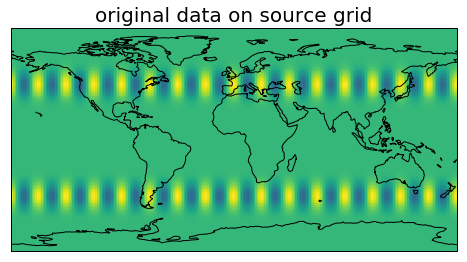

In [9]:
def plot_datafield(ax, ds, data):
    ax.pcolormesh(ds['lon_b'], ds['lat_b'], data,
                  vmin=0, vmax=3)
    ax.coastlines()

fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection=ccrs.PlateCarree())

plot_datafield(ax, ds_in, ds_in['data2'])
ax.set_global()
ax.set_title('original data on source grid', fontsize=20)

# Apply regridding

In [10]:
outdata = xeb.esmf_regrid_apply(regrid, ds_in['data2'].values.T)
outdata.shape

(360, 180)

In [11]:
ds_out

<xarray.Dataset>
Dimensions:  (x: 360, x_b: 361, y: 180, y_b: 181)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 ...
    lon_b    (y_b, x_b) float64 -180.0 -179.0 -178.0 -177.0 -176.0 -175.0 ...
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 -90.0 -90.0 -90.0 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [12]:
ds_out['data2'] = (['y', 'x'], outdata.T)

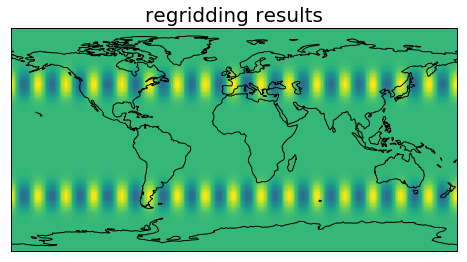

In [13]:
fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection=ccrs.PlateCarree())

plot_datafield(ax, ds_out, ds_out['data2'])
ax.set_global()
ax.set_title('regridding results', fontsize=20)

# Free memory

In [14]:
xeb.esmf_regrid_finalize(regrid)

In [15]:
regrid.dstfield.data # data still exist

array([[ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       ..., 
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.]])

# Test broadcast

In [16]:
extra_dims = [50, 10] # lev, time

In [18]:
%%time
regrid_4D = xeb.esmf_regrid_build(sourcegrid, dstgrid, 
                                  'conservative', extra_dims=extra_dims)

CPU times: user 3.95 s, sys: 143 ms, total: 4.1 s
Wall time: 4.18 s


In [19]:
# add time and level coordinates
ds_in.coords['time'] = np.arange(1, extra_dims[1]+1)
ds_in.coords['lev'] = np.arange(1, extra_dims[0]+1)
ds_in

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 288, x_b: 289, y: 120, y_b: 121)
Coordinates:
    lon      (y, x) float64 -179.4 -178.1 -176.9 -175.6 -174.4 -173.1 -171.9 ...
    lat      (y, x) float64 -89.25 -89.25 -89.25 -89.25 -89.25 -89.25 -89.25 ...
    lon_b    (y_b, x_b) float64 -180.0 -178.8 -177.5 -176.2 -175.0 -173.8 ...
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 -90.0 -90.0 -90.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data1    (y, x) float64 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 ...
    data2    (y, x) float64 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 ...

In [20]:
# let it increases linearly with time and lev to test broadcasting
ds_in['data4D'] = ds_in['time'] * ds_in['lev'] * ds_in['data2']
ds_in # extra_dims needs to be reverted, since we will pass tranpose

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 288, x_b: 289, y: 120, y_b: 121)
Coordinates:
    lon      (y, x) float64 -179.4 -178.1 -176.9 -175.6 -174.4 -173.1 -171.9 ...
    lat      (y, x) float64 -89.25 -89.25 -89.25 -89.25 -89.25 -89.25 -89.25 ...
    lon_b    (y_b, x_b) float64 -180.0 -178.8 -177.5 -176.2 -175.0 -173.8 ...
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 -90.0 -90.0 -90.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data1    (y, x) float64 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 ...
    data2    (y, x) float64 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 ...
    data4D   (time, lev, y, x) float64 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 ...

In [21]:
%%time
outdata_4D = xeb.esmf_regrid_apply(regrid_4D, ds_in['data4D'].values.T).T

CPU times: user 654 ms, sys: 190 ms, total: 843 ms
Wall time: 851 ms


In [22]:
outdata_4D.shape

(10, 50, 180, 360)

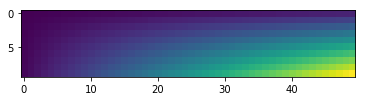

In [23]:
plt.imshow(outdata_4D.mean(axis=(2,3)))

# Use Scipy regridding

In [24]:
ds_in['lon'].size, ds_out['lon'].size

(34560, 64800)

In [25]:
import xesmf.smm as xes

import importlib
importlib.reload(xes)

<module 'xesmf.smm' from '/Users/zhuangjw/Research/Computing/ESMPy-xarray/xESMF/xesmf/smm.py'>

In [26]:
A = xes.read_weights("weights1.nc", ds_in['lon'].size, ds_out['lon'].size)

In [27]:
A.shape # N_out, N_in

(64800, 34560)

In [28]:
data4D_in = ds_in['data4D'].values

In [29]:
Nlat_out, Nlon_out = ds_out['lon'].shape
Nlat_out, Nlon_out

(180, 360)

In [30]:
%time outdata_scipy = xes.apply_weights(A, data4D_in, Nlon_out, Nlat_out)

CPU times: user 177 ms, sys: 78.3 ms, total: 255 ms
Wall time: 255 ms


In [31]:
outdata_scipy.shape

(10, 50, 180, 360)

In [32]:
np.allclose(outdata_scipy, outdata_4D)

True

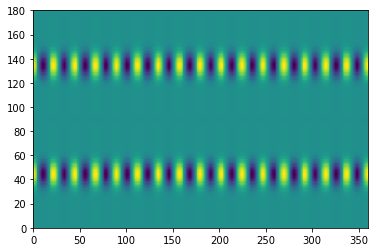

In [33]:
plt.pcolormesh(outdata_scipy.mean(axis=(0,1)))

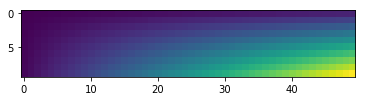

In [34]:
plt.imshow(outdata_scipy.mean(axis=(2,3)))